# Interview Question:
## Tomorrow’s Rain Forecast for New York<br>
The Historical Hourly Weather Data 2012-2017 on Kaggle contains 5 years of hourly measurements of various weather attributes, such as temperature, humidity, air pressure, etc. The data are available to download from Kaggle at the following link:<br>
https://www.kaggle.com/selfishgene/historical-hourly-weather-data<br>
### Task: 
<br>Given historical weather data, can you predict whether tomorrow will be rainy in New York? Any weather description that is a form of liquid precipitation is considered rainy, such as those containing keywords “rain”, “thunderstorm”, “drizzle”, etc. You have flexibility in defining “rainy" and “tomorrow” (e.g. next 24 hours from current hour); no matter what your definitions are, please make them clear in the report.
In the open-ended quiz, please make sure you address the following questions:
- Define metrics to evaluate algorithm performance
- What are your training, validation, and testing sets?
- Implement a simple baseline
- Compare the performance of one more algorithm to the baseline
- At least one algorithm should use a machine-learning/deep-learning approach

### Tina's Comments:

- Assumptions/Interpretation of the problem statement: <br>
Do not have access to hourly new data to do immediate next hour prediction. Need to do 24 hour batch prediction at once in the future.
<br><br>
- Definitions:
<br>    Tomorrow: next 24 hours from the current hour
<br>    Rainny: any weather condition satisfied “rain”, “thunderstorm”, “drizzle”
<br><br>
- Target: Next 24 hours rain/no rain prediction from the current hour

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Flatten, TimeDistributed, Conv1D, MaxPool1D, Dropout
from warnings import catch_warnings
from warnings import filterwarnings
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns
import time
from utils import plot_loss_history, plot_roc, tsplot, evaluate_perf
from data_generater import *
from inference_generator import inferenceGenerator
%matplotlib inline

### Step 1: Load and Clean Data

In [2]:
dataset_dir = 'historical-hourly-weather-data'
city='New York'
weather_generator = weatherDataGenerator(dataset_dir,city)
ny_df = weather_generator.create_city_dataset()
ny_df.head()

,weather_description,humidity,wind_direction,temperature,pressure,wind_speed
datetime,,,,,,
2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-01 13:00:00,few clouds,58.0,260.0,288.220000,1012.0,7.0
2012-10-01 14:00:00,few clouds,57.0,260.0,288.247676,1012.0,7.0
2012-10-01 15:00:00,few clouds,57.0,260.0,288.326940,1012.0,7.0
2012-10-01 16:00:00,few clouds,57.0,260.0,288.406203,1012.0,7.0


In [3]:
# check if there is any invalid field in the dataset
ny_df.isnull().sum()
ny_df.reset_index(inplace=True)
ny_df['datetime']=pd.to_datetime(ny_df['datetime'])
ny_df = ny_df.set_index('datetime')
ny_df.isnull().sum()

weather_description     793
humidity               1624
wind_direction          793
temperature             793
pressure               1041
wind_speed              793
dtype: int64

In [59]:
weather_generator.simple_fill_na(ny_df) 
# For missing data on weather condition values, I simply propogate the last valid number to the NaNs. 
# For the missing weather description, I put in None.
# Potential improvement. Use interpolation or regression to estimate/impute the missing values.
print(ny_df.isnull().sum())
len(ny_df)

weather_description    0
humidity               0
wind_direction         0
temperature            0
pressure               0
wind_speed             0
rainny                 0
dtype: int64


45253

#### Now add another column with rain / no rain  label inferred from weather description column,

In [70]:
interested_features=['humidity','temperature','pressure','wind_direction','wind_speed','rainny']
consolidated_ny_df=weather_generator.consolidate_weather_condition(interested_features, ny_df)

In [71]:
consolidated_ny_df['rain_prev_hour'] = consolidated_ny_df['rainny'].shift(1)
consolidated_ny_df.head()

,humidity,temperature,pressure,wind_direction,wind_speed,rainny,rain_prev_hour
datetime,,,,,,,
2012-10-01 12:00:00,58.0,288.220000,1012.0,260.0,7.0,0,NaN
2012-10-01 13:00:00,58.0,288.220000,1012.0,260.0,7.0,0,0.0
2012-10-01 14:00:00,57.0,288.247676,1012.0,260.0,7.0,0,0.0
2012-10-01 15:00:00,57.0,288.326940,1012.0,260.0,7.0,0,0.0
2012-10-01 16:00:00,57.0,288.406203,1012.0,260.0,7.0,0,0.0


In [72]:
# Add column that indicates whether there is rain in next 24 hours.
day_rain_labels=[]
for i in range(len(consolidated_ny_df)-24):
    ret = sum(consolidated_ny_df['rainny'][i+1:i+25])>=1
    day_rain_labels.append(ret)
labels = np.array(day_rain_labels).astype(int)
print(labels.shape)

(45229,)


In [73]:
dummy_labels=np.zeros(24)
dummy_labels.fill(np.nan)
label_col=np.concatenate((labels, dummy_labels), axis=None)
consolidated_ny_df['next24_rain']=label_col
print(len(consolidated_ny_df))

45253


### Step 2: Explore the data and select features

Let's explore the data a bit more to see what variables may have bigger impact on rain conditions.
I'm going to exam the existing 5 features. But there may be some additional features we can extract to help on the prediction task.
From common sense, rain or not should have nothing to do with a specific day. But I suspect it may have some correlation with:<br>
- month
- time (hour) of the day
- etc.
<br><br>Let's add more features.

In [9]:
consolidated_ny_df['month']=pd.to_datetime(consolidated_ny_df.index).month
consolidated_ny_df['hour']=pd.to_datetime(consolidated_ny_df.index).hour

Let's look at the correlation between different variables.

In [10]:
consolidated_ny_df.corr()

,humidity,temperature,pressure,wind_direction,wind_speed,rainny,rain_prev_hour,next24_rain,month,hour
humidity,1.000000,-0.056863,-0.074133,-0.186597,-0.249834,0.225169,0.222917,0.218838,0.078683,-0.222376
temperature,-0.056863,1.000000,-0.197179,-0.110307,-0.161306,0.080244,0.077590,0.245546,0.308718,0.142517
pressure,-0.074133,-0.197179,1.000000,-0.121364,-0.125843,-0.100910,-0.107730,-0.116476,-0.028089,-0.012117
wind_direction,-0.186597,-0.110307,-0.121364,1.000000,0.197051,-0.064231,-0.053139,-0.128123,-0.100598,-0.006576
wind_speed,-0.249834,-0.161306,-0.125843,0.197051,1.000000,0.036922,0.039161,-0.058350,-0.067957,0.116140
rainny,0.225169,0.080244,-0.100910,-0.064231,0.036922,1.000000,0.559004,0.287630,-0.016721,0.022024
rain_prev_hour,0.222917,0.077590,-0.107730,-0.053139,0.039161,0.559004,1.000000,0.262955,-0.016750,0.010702
next24_rain,0.218838,0.245546,-0.116476,-0.128123,-0.058350,0.287630,0.262955,1.000000,0.019549,0.008623
month,0.078683,0.308718,-0.028089,-0.100598,-0.067957,-0.016721,-0.016750,0.019549,1.000000,0.000176
hour,-0.222376,0.142517,-0.012117,-0.006576,0.116140,0.022024,0.010702,0.008623,0.000176,1.000000


In [11]:
# sns.pairplot(consolidated_ny_df)

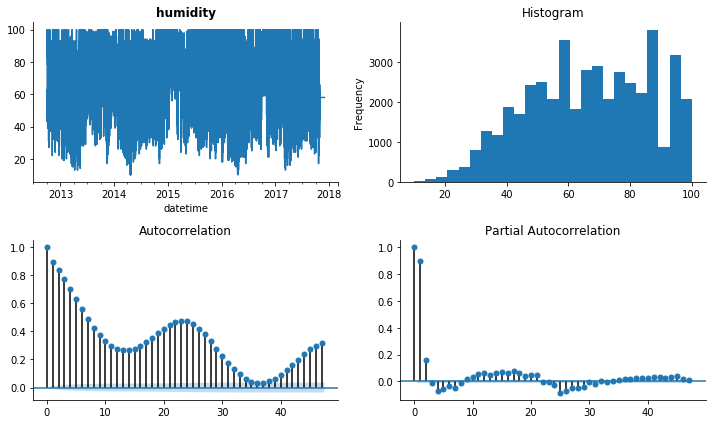

(<matplotlib.axes._subplots.AxesSubplot at 0x13f066a20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1417490f0>)

In [12]:
tsplot(consolidated_ny_df['humidity'],'humidity')

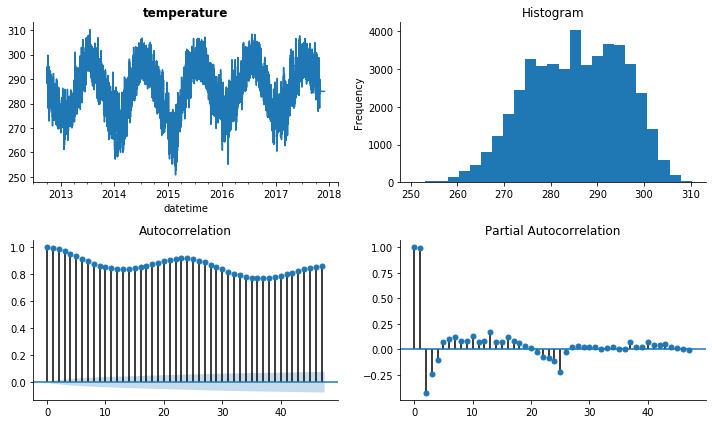

(<matplotlib.axes._subplots.AxesSubplot at 0x13fd0fef0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13e2d6be0>)

In [13]:
tsplot(consolidated_ny_df['temperature'],'temperature')

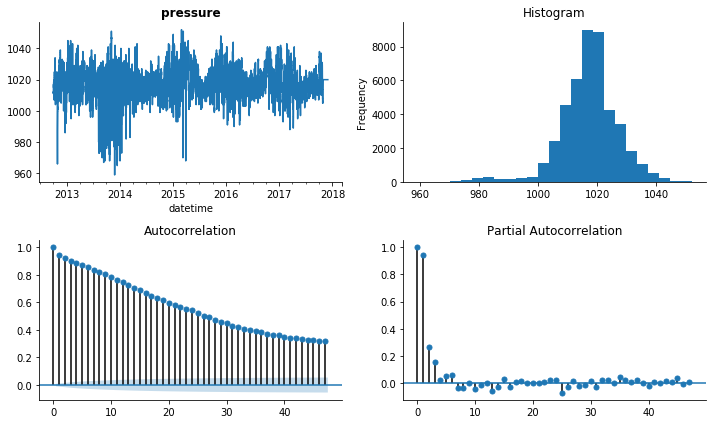

(<matplotlib.axes._subplots.AxesSubplot at 0x1403a86d8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13e3ba208>)

In [14]:
tsplot(consolidated_ny_df['pressure'],'pressure')

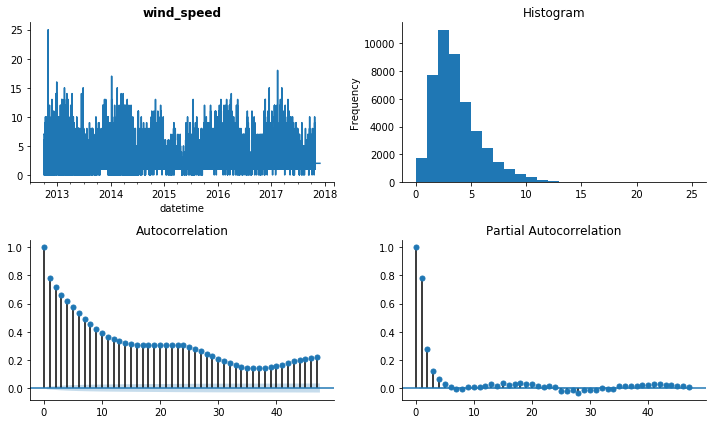

(<matplotlib.axes._subplots.AxesSubplot at 0x1400e07b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13ff4d048>)

In [15]:
tsplot(consolidated_ny_df['wind_speed'],'wind_speed')

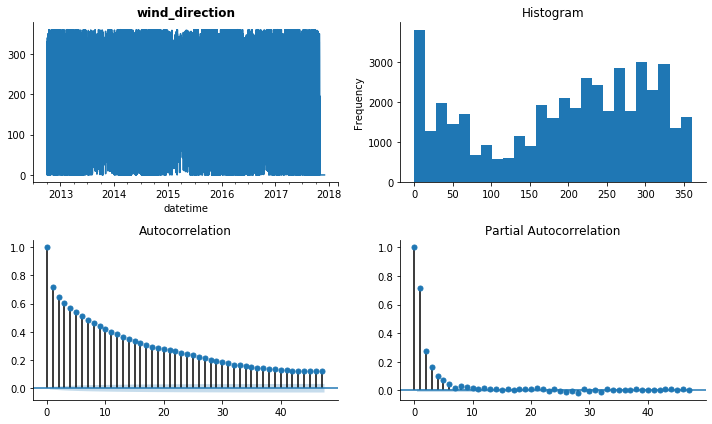

(<matplotlib.axes._subplots.AxesSubplot at 0x142c85eb8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1407822e8>)

In [16]:
tsplot(consolidated_ny_df['wind_direction'],'wind_direction')

There's definitely seasonlaity embedded in every one of these features. We should add some lag variables as well.

In [74]:
consolidated_ny_df['humidity_lagged']= consolidated_ny_df['humidity'].diff()
consolidated_ny_df['temperature_lagged']=consolidated_ny_df['temperature'].diff()
consolidated_ny_df['pressure_lagged']=consolidated_ny_df['pressure'].diff()
consolidated_ny_df['wd_lagged']=consolidated_ny_df['wind_direction'].diff()
consolidated_ny_df['ws_lagged']=consolidated_ny_df['wind_speed'].diff()
consolidated_ny_df = consolidated_ny_df[1:] # remove NaNs due to lagged variables
print(len(consolidated_ny_df))

45252


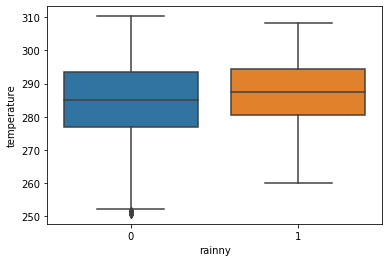

In [18]:
ax_rt = sns.boxplot(x="rainny", y="temperature", data=consolidated_ny_df)

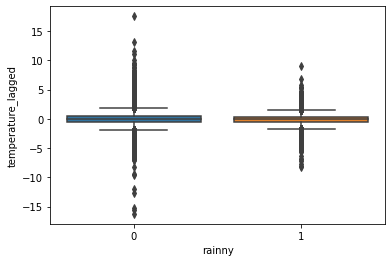

In [19]:
ax_rtl = sns.boxplot(x="rainny", y="temperature_lagged", data=consolidated_ny_df)

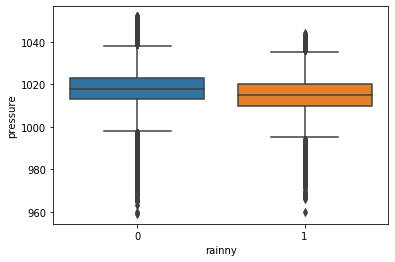

In [20]:
ax_rp = sns.boxplot(x="rainny", y="pressure", data=consolidated_ny_df)

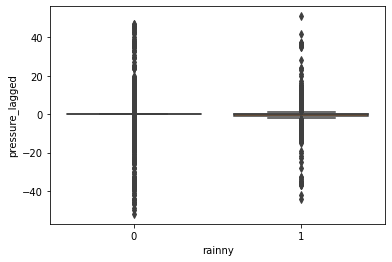

In [21]:
ax_rpl = sns.boxplot(x="rainny", y="pressure_lagged", data=consolidated_ny_df)

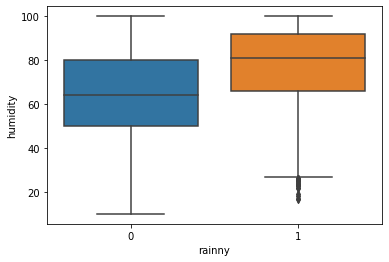

In [22]:
ax_rh = sns.boxplot(x="rainny", y="humidity", data=consolidated_ny_df)

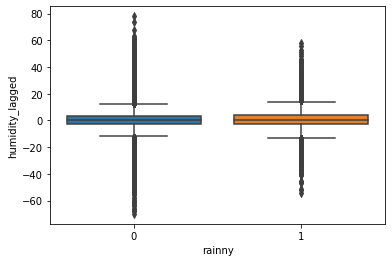

In [23]:
ax_rhl = sns.boxplot(x="rainny", y="humidity_lagged", data=consolidated_ny_df)

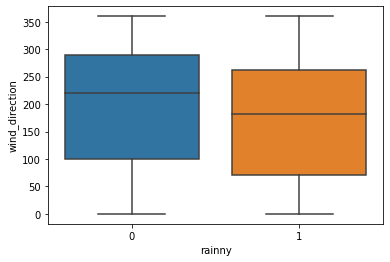

In [24]:
ax_wd = sns.boxplot(x="rainny", y="wind_direction", data=consolidated_ny_df)

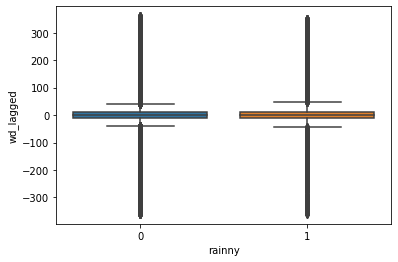

In [25]:
ax_wdl = sns.boxplot(x="rainny", y="wd_lagged", data=consolidated_ny_df)

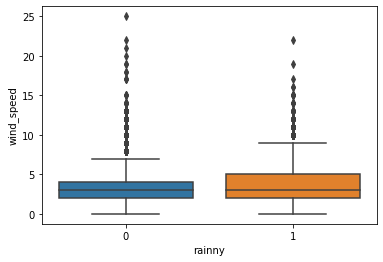

In [26]:
ax_ws = sns.boxplot(x="rainny", y="wind_speed", data=consolidated_ny_df)

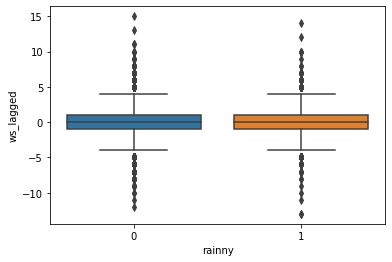

In [27]:
ax_wsl = sns.boxplot(x="rainny", y="ws_lagged", data=consolidated_ny_df)

We may not need to use all the generated features in the end, but does not hurt to generate them.

### Step 3: Generate Simple Baseline
Before diving into fancy machine learning world, I want to make sure we create a simple baseline using first principle or common sense rules. This way, we have a baseline to compare with when it comes to performance. Not all problems need to be solved using complex machine learning models. In the end, if a simple rule or equation solves the problem the best, we should use it instead of any machine learning.

### Naive Method 1

In [28]:
# Let's look at how many hours did it rain in training set
TRAIN_SPLIT=len(consolidated_ny_df)-365*24
hours_rained = consolidated_ny_df['rainny'][:TRAIN_SPLIT].sum()
percentage_rain=hours_rained*1./TRAIN_SPLIT
print(percentage_rain)

0.1466348788775622


Here we assume latest 365 days distribution is similar to previous years. And since the percentage for rain in previous years is low, if I set no rain for all hours over the next 365 days, how is the performance going to be?

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy: 0.8857305936073059
Balanced Accuracy: 0.5
Precision: 0.0
Recall: 0.0
Confusion Matrix:
[[7759    0]
 [1001    0]]


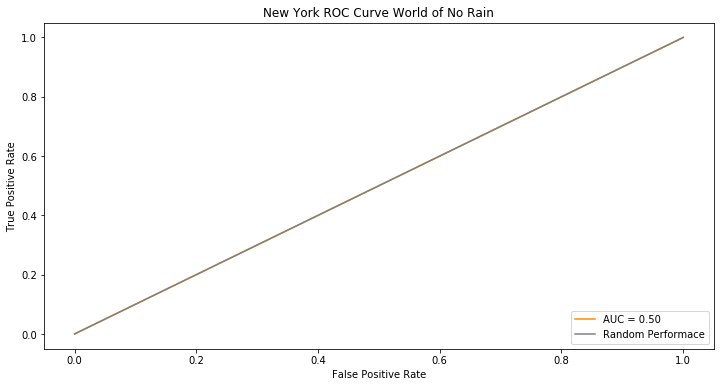

In [29]:
gt=consolidated_ny_df['rainny'][TRAIN_SPLIT:]
pred=np.zeros(365*24)
evaluate_perf(pred,gt,'World of No Rain')

Accuracy is 88.57%, this is actually really high! But of course you will never predict any positives. 
<br>In fact, we get this high of accuracy only because this dataset in very imbalanced. So we should look at the normalized (balanced) accuracy instead. Not surprisingly, it is 0.5, no better than a random performance.

### Naive Method 2
Let's assume the next 24 hour weather is going to be the same as its previous 24 hour's.

Accuracy: 0.8113013698630137
Balanced Accuracy: 0.5358598741122262
Precision: 0.17722772277227722
Recall: 0.17882117882117882
Confusion Matrix:
[[6928  831]
 [ 822  179]]


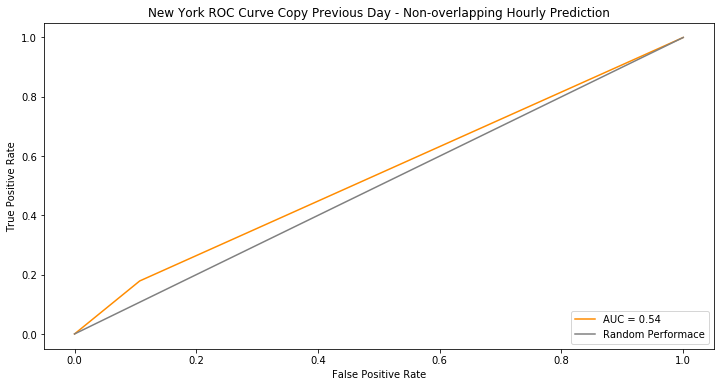

In [30]:
# To keep testset the same, I will only run this loigc on latest 365 days.
pred=consolidated_ny_df['rainny'][TRAIN_SPLIT-24:-24]
evaluate_perf(pred,gt,'Copy Previous Day - Non-overlapping Hourly Prediction')

If we do the performance analysis in a rolling window fashion, with a lot of samples overlapping.

In [65]:
rainny_gt_list=consolidated_ny_df['rainny'].tolist()
print(len(rainny_gt_list))
pred_hourly_rain_labels=[]
for i in range(len(rainny_gt_list)-365*24-2*24,len(rainny_gt_list)-2*24):
    ret = rainny_gt_list[i:i+24] # copy previous 24 hours of rain as prediction for current 24 hours
    pred_hourly_rain_labels.append(ret)

rolling_hourly_pred = np.array(pred_hourly_rain_labels).astype(int)
print(rolling_hourly_pred.shape)
print(rolling_hourly_pred)

45252
(8760, 24)
[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [32]:
rolling_hourly_gt=[]
for i in range(len(rainny_gt_list)-365*24-24,len(rainny_gt_list)-24):
    ret = rainny_gt_list[i:i+24]
    rolling_hourly_gt.append(ret)
rolling_hourly_gt=np.array(rolling_hourly_gt).astype(int)
print(rolling_hourly_gt.shape)
print(rolling_hourly_gt)

(8760, 24)
[[1 1 0 ... 1 0 1]
 [1 0 1 ... 0 1 0]
 [0 1 1 ... 1 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Accuracy: 0.8108590182648402
Balanced Accuracy: 0.5359069815979152
Precision: 0.17794620422622234
Recall: 0.17904509283819628
Confusion Matrix:
[[166155  19957]
 [ 19808   4320]]


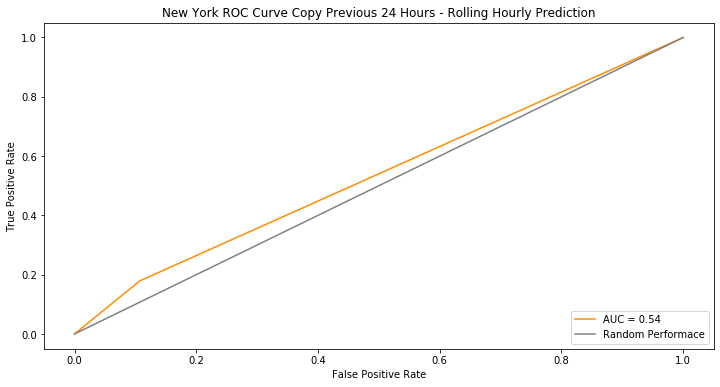

In [33]:
evaluate_perf(rolling_hourly_pred.ravel(),rolling_hourly_gt.ravel(),'Copy Previous 24 Hours - Rolling Hourly Prediction')

Okay, this method yields slightly better than random performance for every hour prediction.<br>
What about we aggregate the information for hourly prediction and do a day prediction as end result?

Now Let's do rolling 24 hour window with 1 hour as step. This way, we predict the next 24 hour (tomorrow) weather for every current hour. Then aggregate each predicted window of 24 hour data for a day's rain prediction and compare with the aggregated day's rain label for the same window of 24 hours from the ground truth.

Accuracy: 0.6622146118721461
Balanced Accuracy: 0.6597481422209396
Precision: 0.6865546218487395
Recall: 0.6901795142555438
Confusion Matrix:
[[2533 1492]
 [1467 3268]]


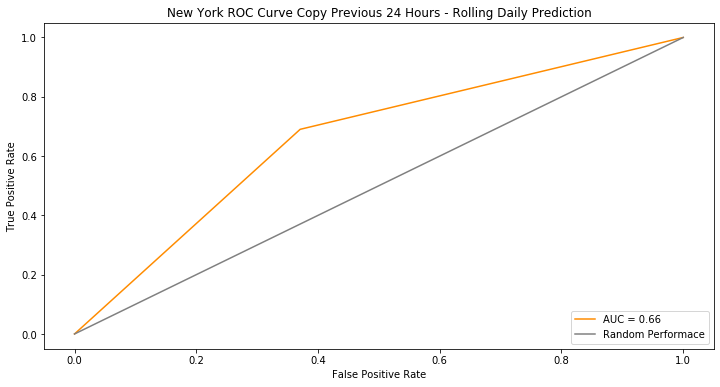

In [34]:
pred_rain_labels=[]
for i in range(len(consolidated_ny_df)-365*24-24,len(consolidated_ny_df)-24):
    ret = sum(consolidated_ny_df['rainny'][i-24:i])>=1 # since prediction is just copying previous 24 hours data, so we are aggregating previous 24 hours data
    pred_rain_labels.append(ret)
rolling_pred = np.array(pred_rain_labels).astype(int)
# print(rolling_pred.shape)
rolling_gt=consolidated_ny_df['next24_rain'][len(consolidated_ny_df)-365*24-24:len(consolidated_ny_df)-24]
# print(rolling_gt.shape)
evaluate_perf(rolling_pred,rolling_gt,'Copy Previous 24 Hours - Rolling Daily Prediction')

After agrregation, the results look more reasonable. The overall performance metrics show that this naive first principle method model is very balanced in terms of daily rain prediction. I bet we can achieve better performance by taking additional factors (humidity, month, and etc) into account. But for now this is a good baseline to compare with. Let's see if we can do better with some machine learning techniques.

### Step 4: Train, Validation, Test Dataset Preparation
I'm going to approaching this problem as one-shot multi-step classification problem with supervised learning.
<br>The long time series dataset will be split into overlapping sequences of short time series with fixed length (multiples of 24 in this case) as one individual sample. <br>The target will be 24-step classifications to predict next 24 hours rain condition in one-shot.

In [64]:
# Now generate input and labels
selected_features = ['humidity', 'pressure','temperature','wind_direction', 'wind_speed','rainny']
# selected_features = ['humidity', 'pressure','temperature','wind_direction', 'wind_speed','humidity_lagged', 'pressure_lagged','temperature_lagged','wd_lagged', 'ws_lagged','rainny']
# I've tried additional features but they don't help but making training longer
label_col ='rainny'
print(len(consolidated_ny_df))
dataset_generator = datasetGenerator(consolidated_ny_df,selected_features, label_col)

45252


In [36]:
# step_size=24
input_step=2*24 # past N*24 hours as input, 2 days is a sweet spot after some experiments
output_step=24 # next 24 hour forecast
sequence_inputs,sequence_labels = dataset_generator.generate_rolling_sequence_data(input_step, output_step)
print(sequence_inputs.shape)
print(sequence_labels.shape)

(45181, 48, 6)
(45181, 24)


I split the sequenced dataset into train, validation, and test sets.<br>
- train: samples generaed from roughly first 3 years 
- validation: samples generated from second last 365 days
- test: samples generated from last 365 days 

In [37]:
train, val, test = len(sequence_inputs)-2*24*365, 365*24, 365*24 # need to guarantee 1 year year of test data to represent the population
Xtrain, Xval, Xtest, ytrain, yval, ytest = dataset_generator.split_data(sequence_inputs, sequence_labels, train, val, test)

In [38]:
Xtrain_scaled = dataset_generator.scale_features(0, Xtrain.shape[0], Xtrain)
Xval_scaled = dataset_generator.scale_features(Xtrain.shape[0], Xtrain.shape[0]+Xval.shape[0], Xval)
Xtest_scaled = dataset_generator.scale_features(Xtrain.shape[0]+Xval.shape[0], len(dataset_generator.X), Xtest)

### Step 5: Build some ML models

#### All the models I build below will serve Multivariate Multi-step One-shot classification purpose.

#### Simple 1D CNN + Classifier layer
CNN is known for its good performance and its capability for local feature extractions. It might do a good job in identifying patterns in short time sequences and serve the purpose of prediction.

In [39]:
cnn_model = tf.keras.Sequential()
cnn_model.add(Conv1D(filters=16, kernel_size=3, input_shape=(Xtrain_scaled.shape[1], Xtrain_scaled.shape[2])))
cnn_model.add(MaxPool1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(24,activation='sigmoid'))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 46, 16)            304       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 23, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 368)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                8856      
Total params: 9,160
Trainable params: 9,160
Non-trainable params: 0
_________________________________________________________________


Since train and validation losses may fluctuate over the number of epochs, we may have achieved at best model before end of training.<br> So it is best practice to save the best model in the middle of the training. I'm adding a callback during training to only save based on the lowest validation loss.

In [40]:
saved_model_path=os.path.join(os.getcwd(),'trained_models/CNN.hdf5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=saved_model_path,
        save_best_only=True,
        monitor='val_loss',
        save_weights_only=True,
        verbose=1
    )

In [41]:
cnn_history = cnn_model.fit(Xtrain_scaled,ytrain, epochs=20, validation_data=(Xval_scaled,yval), shuffle=True, callbacks=[model_checkpoint_callback])

Train on 27661 samples, validate on 8760 samples
Epoch 1/20
27008/27661 [============================>.] - ETA: 0s - loss: 0.3825 - accuracy: 0.8579
Epoch 00001: val_loss improved from inf to 0.40892, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/trained_models/CNN.hdf5
27661/27661 [==============================] - 3s 93us/sample - loss: 0.3821 - accuracy: 0.8580 - val_loss: 0.4089 - val_accuracy: 0.8505
Epoch 2/20
27488/27661 [============================>.] - ETA: 0s - loss: 0.3660 - accuracy: 0.8634
Epoch 00002: val_loss improved from 0.40892 to 0.39434, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/trained_models/CNN.hdf5
27661/27661 [==============================] - 2s 66us/sample - loss: 0.3662 - accuracy: 0.8633 - val_loss: 0.3943 - val_accuracy: 0.8500
Epoch 3/20
27392/27661 [============================>.] - ETA: 0s - loss: 0.3639 - accuracy: 0.8635
Epoch 00003: val_loss did not improve from 0.39434
27661/27661 [===========

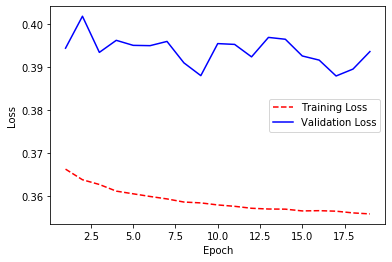

In [42]:
plot_loss_history(cnn_history)

From the above Loss plot, we can see the model is overfitting at the end. I've tuned the following hyperparameters:
- number of layer
- number of activation units per layer
- optimization method

The current hyperparameter set I am using is already the optimal for short sequence inputs(1-3 days).<br>
I've also tried make training data sample longer (7-14 days). The model is not taking longer samples well (training takes longer, performance degrades regardless of hyperparameter changes). It performs better with shorter samples.

Accuracy: 0.7971270928462709
Balanced Accuracy: 0.6259434865266948
Precision: 0.25631446011366027
Recall: 0.4037632625994695
Confusion Matrix:
[[157846  28266]
 [ 14386   9742]]


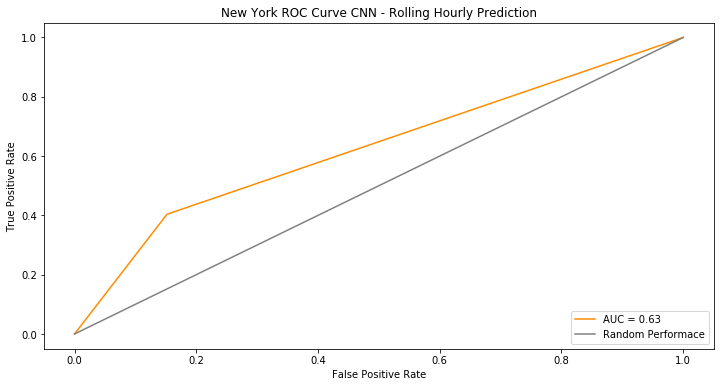

In [43]:
# Now load the saved best model and run inference
saved_model_path=os.path.join(os.getcwd(),'trained_models/CNN.hdf5')
cnn_model.load_weights(saved_model_path)
predictions=cnn_model.predict(Xtest_scaled)
threshold=0.2 # tunable parameter after training to see if I can get better performance
inference=inferenceGenerator(cnn_model, saved_model_path, Xtest_scaled, ytest,threshold)
rolling_hourly_pred = inference.model_output_consumer()
evaluate_perf(rolling_hourly_pred.ravel(),rolling_hourly_gt.ravel(),'CNN - Rolling Hourly Prediction')

(8760,)
(8760,)
Accuracy: 0.6769406392694064
Balanced Accuracy: 0.686502128329409
Precision: 0.7737855705662546
Recall: 0.568532206969377
Confusion Matrix:
[[3238  787]
 [2043 2692]]


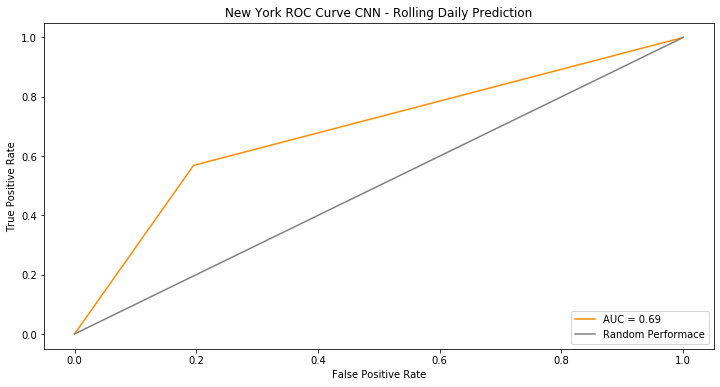

In [44]:
pred_daily_rain_labels=np.array([1 if sum(x)>=1 else 0 for x in rolling_hourly_pred])
print(pred_daily_rain_labels.shape)
rolling_daily_gt=consolidated_ny_df['next24_rain'][len(consolidated_ny_df)-365*24-24:len(consolidated_ny_df)-24]
print(rolling_daily_gt.shape)
evaluate_perf(pred_daily_rain_labels,rolling_daily_gt,'CNN - Rolling Daily Prediction')

Seems like simple CNN is doing much better than Naive method 2 on:<br>
- rolling hourly rain prediction 
- and slightly better on the rolling daily rain prediction

#### LSTM

CNN is very good for feature extraction, but does not have any sense of the order of the input sequence. On the contrast, LSTM is good at capaturing patterns embedded in the order of sequence. So I'm trying a simple LSTM model next to see if it will be a good fit for this task.

In [55]:
# build model
lstm_model = tf.keras.Sequential()
lstm_model.add(LSTM(16, activation='relu', return_sequences=True,input_shape=(Xtrain_scaled.shape[1], Xtrain_scaled.shape[2])))
lstm_model.add(Flatten())
lstm_model.add(Dense(24, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 48, 16)            1472      
_________________________________________________________________
flatten_2 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                18456     
Total params: 19,928
Trainable params: 19,928
Non-trainable params: 0
_________________________________________________________________


In [56]:
saved_model_path=os.path.join(os.getcwd(),'trained_models/LSTM.hdf5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=saved_model_path,
        save_best_only=True,
        monitor='val_loss',
        save_weights_only=True,
        verbose=1
    )

In [57]:
lstm_history = lstm_model.fit(Xtrain_scaled, ytrain, epochs=20, validation_data=(Xval_scaled,yval), shuffle=True, callbacks=[model_checkpoint_callback])

Train on 27661 samples, validate on 8760 samples
Epoch 1/20
27648/27661 [============================>.] - ETA: 0s - loss: 0.3802 - accuracy: 0.8590
Epoch 00001: val_loss improved from inf to 0.39785, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/trained_models/LSTM.hdf5
27661/27661 [==============================] - 19s 676us/sample - loss: 0.3802 - accuracy: 0.8590 - val_loss: 0.3978 - val_accuracy: 0.8476
Epoch 2/20
27616/27661 [============================>.] - ETA: 0s - loss: 0.3612 - accuracy: 0.8639
Epoch 00002: val_loss improved from 0.39785 to 0.39564, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/trained_models/LSTM.hdf5
27661/27661 [==============================] - 17s 608us/sample - loss: 0.3611 - accuracy: 0.8640 - val_loss: 0.3956 - val_accuracy: 0.8500
Epoch 3/20
27616/27661 [============================>.] - ETA: 0s - loss: 0.3561 - accuracy: 0.8654
Epoch 00003: val_loss did not improve from 0.39564
27661/27661 [=====

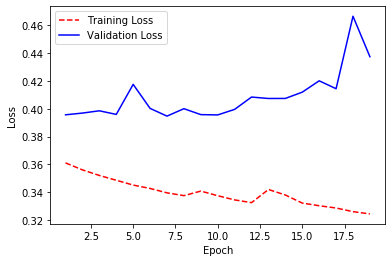

In [60]:
plot_loss_history(lstm_history)

Same overfitting issue at the end. I've also tuned the following hyperparameters:
- number of layer
- number of activation units per layer
- optimization method

The current hyperparameter set I am using is already the optimal for short sequence inputs(1-3 days).<br>
I've also tried make training data sample longer (7-14 days). The model is not taking longer samples well (training takes longer, performance degrades regardless of hyperparameter changesm, some instability issues occured). It performs better with shorter samples.

Accuracy: 0.6264840182648402
Balanced Accuracy: 0.6866023559242955
Precision: 0.2020745251812745
Recall: 0.7646303050397878
Confusion Matrix:
[[113263  72849]
 [  5679  18449]]


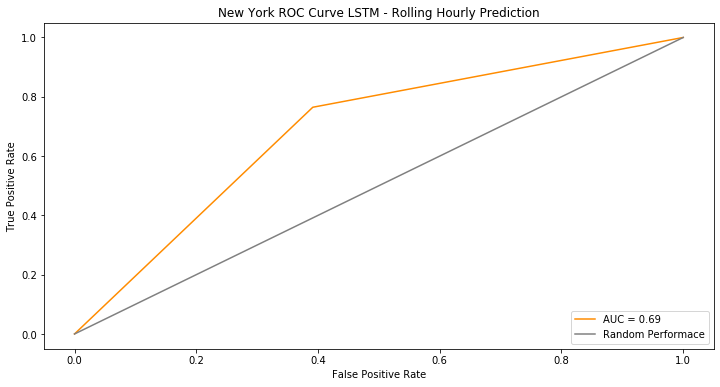

In [61]:
# Now load the saved best model and run inference
saved_model_path=os.path.join(os.getcwd(),'trained_models/LSTM.hdf5')
threshold=0.1 # tunable parameter after training the model to see if I can get better performance
# I tune this number lower to trade higher false positives for higher true positives and lower false negatives. 
# Depending on end user needs, we can change this specific parameter to shift the ROC.
# Personally, I would be more okay with false positives, and not okay with false negatives.
# I will be grumpy if it rains when I am unprepared. 
inference=inferenceGenerator(lstm_model, saved_model_path, Xtest_scaled, ytest,threshold)
rolling_hourly_pred = inference.model_output_consumer()
evaluate_perf(rolling_hourly_pred.ravel(),rolling_hourly_gt.ravel(),'LSTM - Rolling Hourly Prediction')

Accuracy: 0.7222602739726027
Balanced Accuracy: 0.7134292666609824
Precision: 0.7098067808968282
Recall: 0.8223864836325238
Confusion Matrix:
[[2433 1592]
 [ 841 3894]]


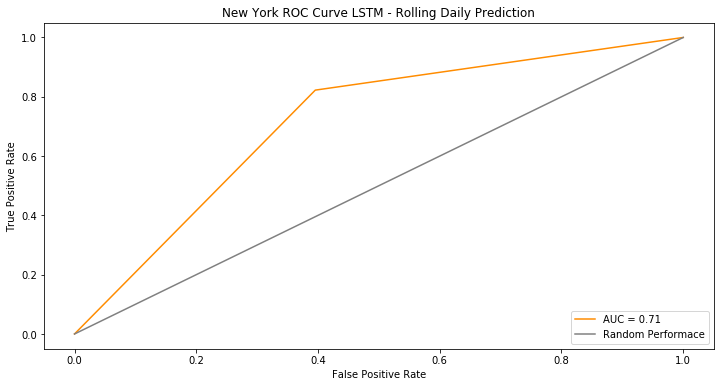

In [62]:
pred_daily_rain_labels=np.array([1 if sum(x)>=1 else 0 for x in rolling_hourly_pred])
evaluate_perf(pred_daily_rain_labels,rolling_daily_gt,'LSTM - Rolling Daily Prediction')

It seems LSTM is a better suited model for this task, which aligns with my expectation. How about if I change to Bidirectional LSTM?

#### Bidirectional LSTM

In [83]:
# build model
blstm_model = tf.keras.Sequential()
blstm_model.add(Bidirectional(LSTM(16, activation='relu', return_sequences=True), input_shape=(Xtrain_scaled.shape[1], Xtrain_scaled.shape[2])))
blstm_model.add(Flatten())
blstm_model.add(Dense(24, activation='sigmoid'))
blstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
blstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 48, 32)            2944      
_________________________________________________________________
flatten_4 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                36888     
Total params: 39,832
Trainable params: 39,832
Non-trainable params: 0
_________________________________________________________________


In [84]:
saved_model_path=os.path.join(os.getcwd(),'trained_models/BLSTM.hdf5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=saved_model_path,
        save_best_only=True,
        monitor='val_loss',
        save_weights_only=True,
        verbose=1
    )

In [85]:
blstm_history = blstm_model.fit(Xtrain_scaled, ytrain, epochs=20, validation_data=(Xval_scaled,yval), shuffle=True, callbacks=[model_checkpoint_callback])

Train on 27661 samples, validate on 8760 samples
Epoch 1/20
27648/27661 [============================>.] - ETA: 0s - loss: 0.3712 - accuracy: 0.8606
Epoch 00001: val_loss improved from inf to 0.39203, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/trained_models/BLSTM.hdf5
27661/27661 [==============================] - 31s 1ms/sample - loss: 0.3712 - accuracy: 0.8606 - val_loss: 0.3920 - val_accuracy: 0.8508
Epoch 2/20
27648/27661 [============================>.] - ETA: 0s - loss: 0.3538 - accuracy: 0.8654
Epoch 00002: val_loss improved from 0.39203 to 0.38864, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/trained_models/BLSTM.hdf5
27661/27661 [==============================] - 26s 941us/sample - loss: 0.3538 - accuracy: 0.8654 - val_loss: 0.3886 - val_accuracy: 0.8524
Epoch 3/20
27616/27661 [============================>.] - ETA: 0s - loss: 0.3486 - accuracy: 0.8667
Epoch 00003: val_loss did not improve from 0.38864
27661/27661 [=====

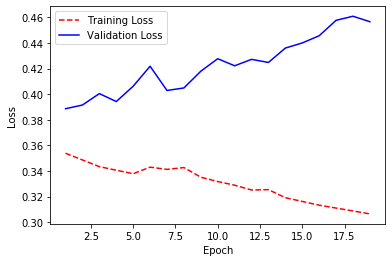

In [86]:
plot_loss_history(blstm_history)

Accuracy: 0.6416666666666667
Balanced Accuracy: 0.6915525496298512
Precision: 0.20806348627200583
Recall: 0.7562997347480106
Confusion Matrix:
[[116656  69456]
 [  5880  18248]]


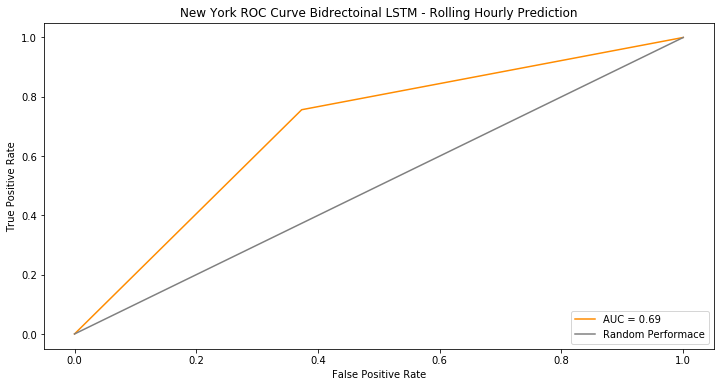

In [87]:
# Now load the saved best model and run inference
saved_model_path=os.path.join(os.getcwd(),'trained_models/BLSTM.hdf5')
threshold=0.1 # tunable parameter after training the model to see if I can get better performance
inference=inferenceGenerator(blstm_model, saved_model_path, Xtest_scaled, ytest,threshold)
rolling_hourly_pred_blstm = inference.model_output_consumer()
evaluate_perf(rolling_hourly_pred_blstm.ravel(),rolling_hourly_gt.ravel(),'Bidrectoinal LSTM - Rolling Hourly Prediction')

Accuracy: 0.739041095890411
Balanced Accuracy: 0.7348008421494487
Precision: 0.7446553446553447
Recall: 0.787117212249208
Confusion Matrix:
[[2747 1278]
 [1008 3727]]


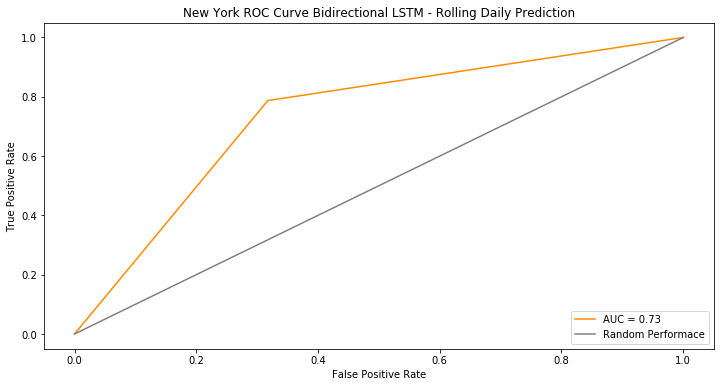

In [88]:
rolling_daily_pred_blstm=np.array([1 if sum(x)>=1 else 0 for x in rolling_hourly_pred_blstm])
evaluate_perf(rolling_daily_pred_blstm,rolling_daily_gt,'Bidirectional LSTM - Rolling Daily Prediction')

Bidirectional LSTM seems to be slightly better than regular LSTM models.

#### Initial Model Exploration Conclusion:

All 3, CNN, LSTM and Bidirectional LSTM models beat the baseline for both hourly and aggregated daily rain predictions. However, they all exhibit overfitting problems even though the models are already simple and shallow. In general, we need a large training dataset with rich features and long training time to make a good performing one-shot multi-step complicated prediction model. This kind of model is expensive to train, but fast at inference. And if it works, it is going to be a simpe and elegant solution. <br><br>
Currently, my datasets are generated with no gap in between the input sequence and target sequence, meaning the previous sequence (multiple of 24 hours chunk) is used for predicting the immediate next 24 hour chunk. While I agree most recent data definitely contributes the most in terms of weather prediction (both fron common sense and from observations of running and evaluating the models), we lost the seasonality info from previous year or even previous quarter around the same time. However, Introducing very long input sequence significantly reduces the number of data samples we can get for training. This can cause worse overfitting problem in my models. In addtition, longer inputs require longer time to train. Given LSTM is already pretty slow and the time constraint of this quiz, I did not explore this route too much. Lastly, I observed longer input sequences tend to cause more instability issues (exploding gradients) in LSTM models during training even though all the features are already normalized. 

### Step 6: Failure Analysis

This is actually one of the most important steps. As this can help guide us on how we should tune our models.
And I still have some time before the quiz deadline. Let's look at our best performing model Bidirectional LSTM and do some preliminary failure analysis.

### False Positives:
From user experience perspective, personally I think positive rain prediction off by +/- 1 hour is very acceptable. So if we apply this criteria, would we be able to move some false positives into the true positive category?

In [98]:
gt_list = dataset_generator.y[-365*24-24:-24]
new_ny_df=ny_df[1:].copy()
test_weather_descriptions = new_ny_df['weather_description'].tolist()[-365*24-24:-24]
unique_weathers=set(ny_df['weather_description'].tolist())
# print(unique_weathers)
unique_rain_conditions=[]
for weather in unique_weathers:
    keywords = ['rain','thunderstorm', 'drizzle'] # will label all instances containing these keywords as "rain", otherwise "no rain"
    for x in keywords:
        if x in weather:
            unique_rain_conditions.append(weather)
print(unique_rain_conditions)

['drizzle', 'proximity thunderstorm', 'light intensity shower rain', 'freezing rain', 'thunderstorm with light rain', 'thunderstorm with light rain', 'proximity thunderstorm with rain', 'proximity thunderstorm with rain', 'thunderstorm with light drizzle', 'thunderstorm with light drizzle', 'heavy intensity rain', 'moderate rain', 'very heavy rain', 'light intensity drizzle', 'light rain and snow', 'thunderstorm', 'shower rain', 'heavy intensity drizzle', 'light rain', 'proximity thunderstorm with drizzle', 'proximity thunderstorm with drizzle', 'thunderstorm with rain', 'thunderstorm with rain', 'thunderstorm with heavy rain', 'thunderstorm with heavy rain', 'heavy thunderstorm']


In [106]:
flattened_pred=rolling_hourly_pred_blstm.ravel()
flattened_gt=rolling_hourly_gt.ravel()

# print('Flattened Predictions:\n',len(flattened_pred),flattened_pred)
# print('Flattened Ground Truth:\n',len(flattened_gt),flattened_gt)
fp_indices = np.where((flattened_pred == 1)& (flattened_gt==0))[0]
fn_indices = np.where((flattened_pred == 0)& (flattened_gt==1))[0]
fp_recoverable=0
error_margin=1
fp_rain_prevalence_dict={key:0 for key in unique_rain_conditions}
for i in range(len(fp_indices)):
    lead_time=int(fp_indices[i]/24)
    window_idx=fp_indices[i]%24
    
    single_prediction = flattened_pred[fp_indices[i]]
    neighbor_gound_truth = gt_list[lead_time+window_idx-error_margin:lead_time+window_idx+error_margin+1]
    neighbor_weather_description=test_weather_descriptions[lead_time+window_idx-error_margin:lead_time+window_idx+error_margin+1]
#     print('Prediction: {}'.format(single_prediction))
#     print('Ground Truth: {}'.format(neighbor_gound_truth))
    if single_prediction in neighbor_gound_truth:
        for neighbor in neighbor_weather_description:
            if neighbor in fp_rain_prevalence_dict:
                fp_rain_prevalence_dict[neighbor]+=1
#         print('Found one correctable:')
#         print('Lead Time: {}; Index inside the window: {}'.format(lead_time,window_idx))
#         print('Prediction: {}'.format(single_prediction))
#         print('Ground Truth: {}'.format(neighbor_gound_truth))
#         print('Weather Description: {}'.format(neighbor_weather_description))
        fp_recoverable+=1
print(fp_recoverable)
print(len(fp_indices))
# print(fp_rain_prevalence_dict)


14062
69456


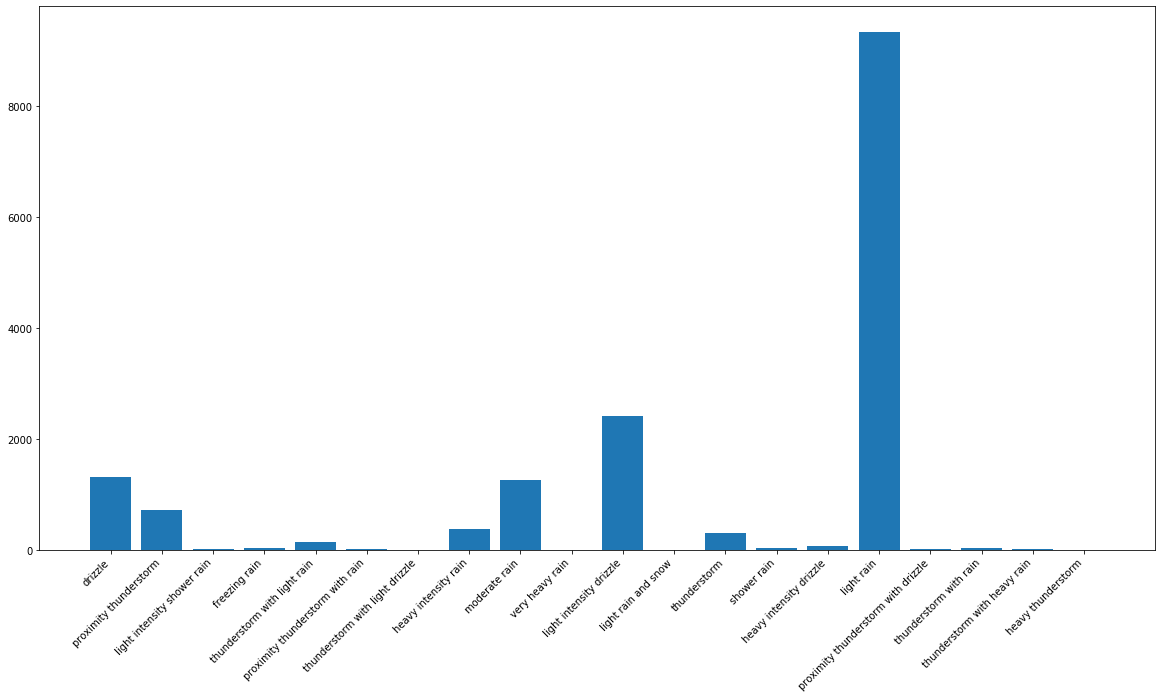

In [107]:
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(range(len(rain_prevalence_dict)), list(rain_prevalence_dict.values()), align='center')
plt.xticks(range(len(rain_prevalence_dict)), list(rain_prevalence_dict.keys()))
ax.set_xticklabels(list(rain_prevalence_dict.keys()), rotation = 45, ha="right")
plt.show()

#### Observations:

- If we loosen our pass/fail criteria for positive predictions, we can reduce 14062 false positives in this version of trained model.(Note this number would vary a little if you retrain.)
- As you can see from the plot, majority of the false positives have preditions wjen the neighbors of the target hour has light precipitation conditions like "drizzle" and "light rain". This makes me if the model has more information about the neighbors having light precipitation conditions, then it will less likely to predict rain or heavy rain if trained properly. I should do more research and come up with a lookup table to map different rain descriptions to different numerical values. Then we can change this problem from a binary classification to a categorical classification problem. And we can custimize the loss function to penalize more on the very wrong predictions. This way, we can potentially build a better model with more information than just "rain/no rain" to feed into the model training from previous times. If time allows, this is on top of the list of things I will try next.

### False Negatives

On the false negative side, let's take a look at the ground truth values around the prediction and see if we can find any pattern. The general philosophy is:<br> <b>If the ground truth in a certain window with the hour of prediction centered are all no rain (negative) labels, then the model is making a reasonable mistake. The bigger the window, the more forgivable the false negative is.

In [109]:
error_margin_space=np.arange(1,13)
fn_potential_forgivables={} 
fn_rain_prevalence_dict_collection={}
for error_margin in error_margin_list:
    fn_tolerable=0
    fn_rain_prevalence_dict={key:0 for key in unique_rain_conditions}
    for i in range(len(fn_indices)):
        lead_time=int(fn_indices[i]/24)
        window_idx=fn_indices[i]%24

        single_prediction = flattened_pred[fn_indices[i]]
        neighbor_gound_truth = gt_list[lead_time+window_idx-error_margin:lead_time+window_idx+error_margin+1]
        neigbor_weather_descriptions=test_weather_descriptions[lead_time+window_idx-error_margin:lead_time+window_idx+error_margin+1]
        if sum(neighbor_gound_truth)==1: # only the centered ground truth is positive
            gt_weather=test_weather_descriptions[lead_time+window_idx]
            if gt_weather in fn_rain_prevalence_dict:
                fn_rain_prevalence_dict[gt_weather]+=1
    #     if single_prediction in neighbor_gound_truth:
#             print('Found one tolerable:')
#             print('Lead Time: {}; Index inside the window: {}'.format(lead_time,window_idx))
#             print('Prediction: {}'.format(single_prediction))
#             print('Ground Truth: {}'.format(neighbor_gound_truth))
            fn_tolerable+=1
#     print(fn_tolerable)
#     print(len(fn_indices))
    fn_potential_forgivables[error_margin]=fn_tolerable
    fn_rain_prevalence_dict_collection[error_margin]=fn_rain_prevalence_dict
print(fn_potential_forgivables)

{1: 1844, 2: 1392, 3: 1031, 4: 878, 5: 793, 6: 667, 7: 601, 8: 528, 9: 473, 10: 437, 11: 414, 12: 391}


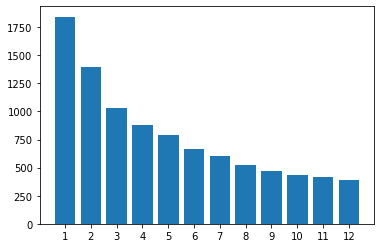

In [93]:
plt.bar(range(len(fn_potential_forgivables)), list(fn_potential_forgivables.values()), align='center')
plt.xticks(range(len(fn_potential_forgivables)), list(fn_potential_forgivables.keys()))
plt.show()

Even though personally I do not like false negaives in this particualr task, we can (if we want) define what is a more sensible window size, and potentially "forgive" some false negatives and admit that this is something the model is going to have a hard time to improve.

The other aspect is if we can get more trainig data that exhibits this pattern of one hour rain in the middle of a variable few hours of no rain, then we can probably do better in these false nagative scenarios.

Now let's look at the ground truth rain descriptions for false negatives.

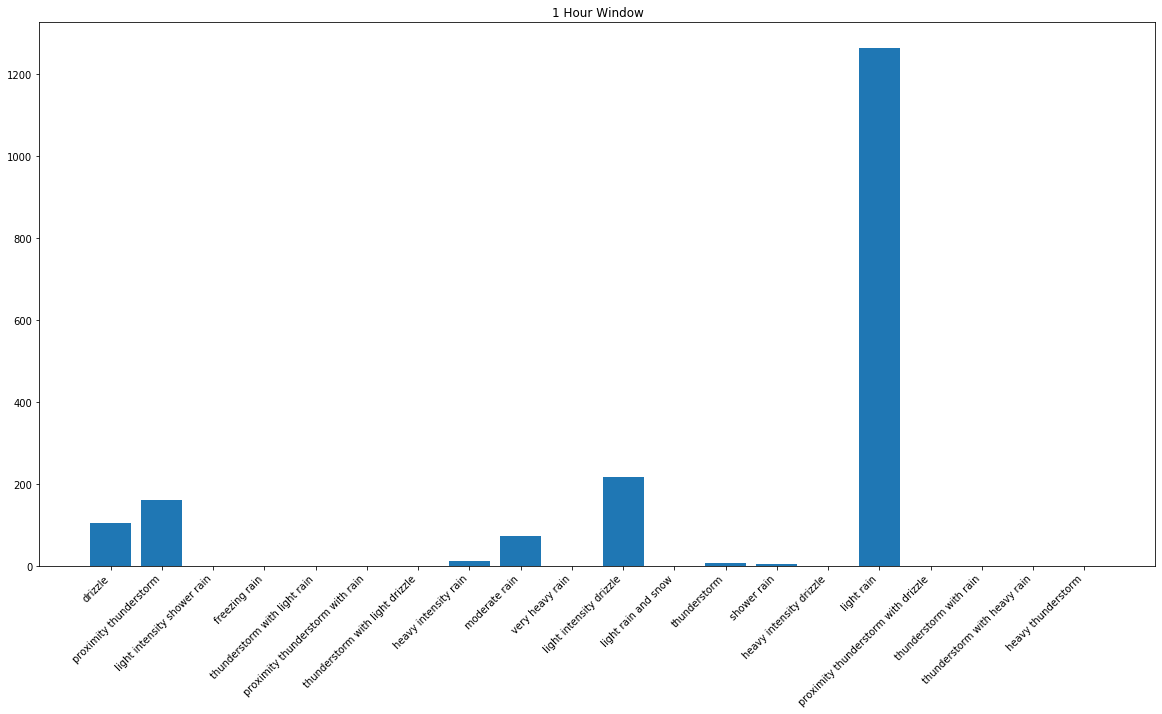

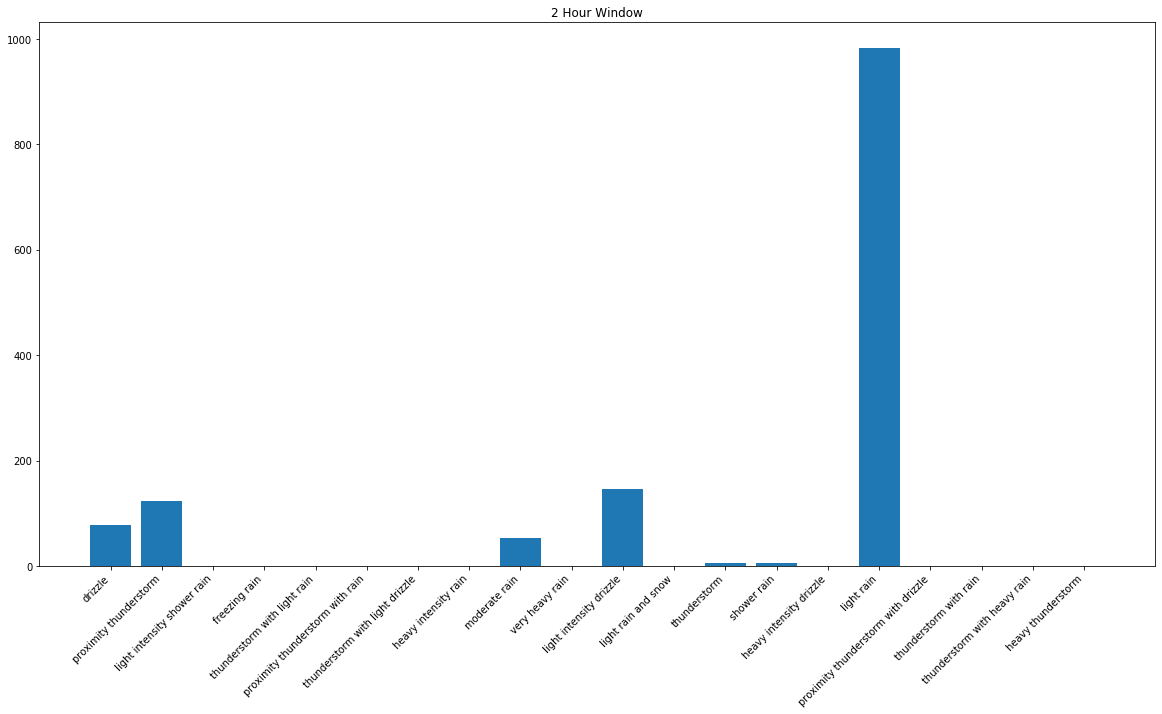

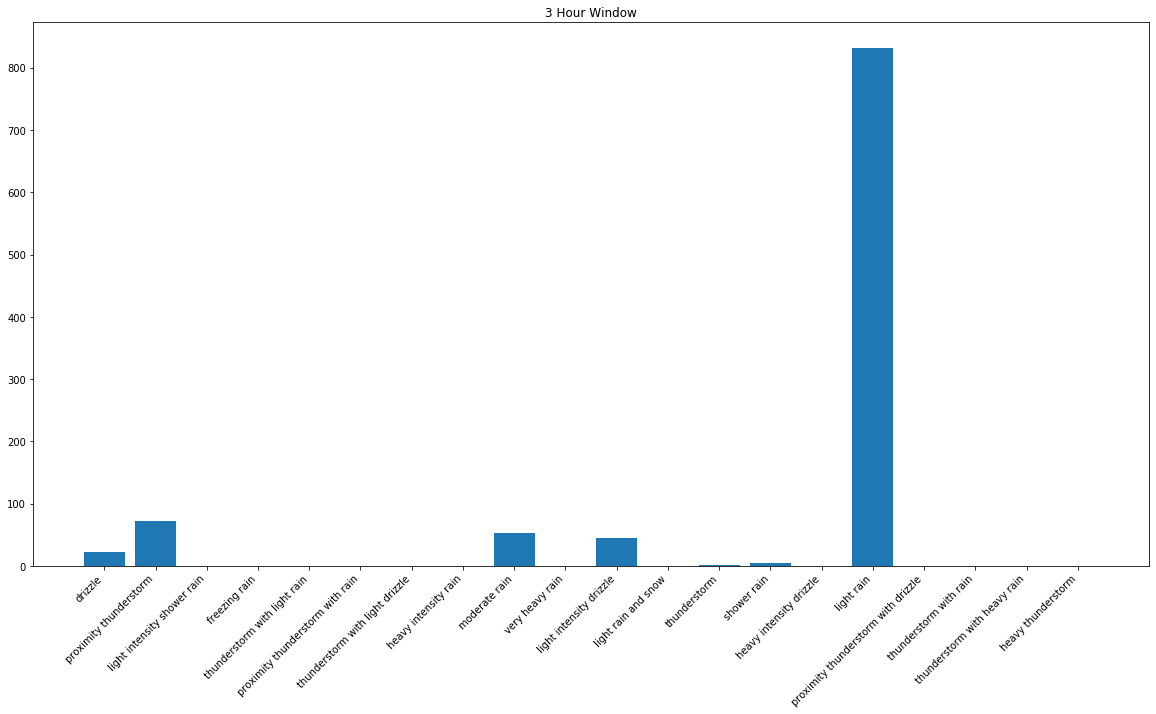

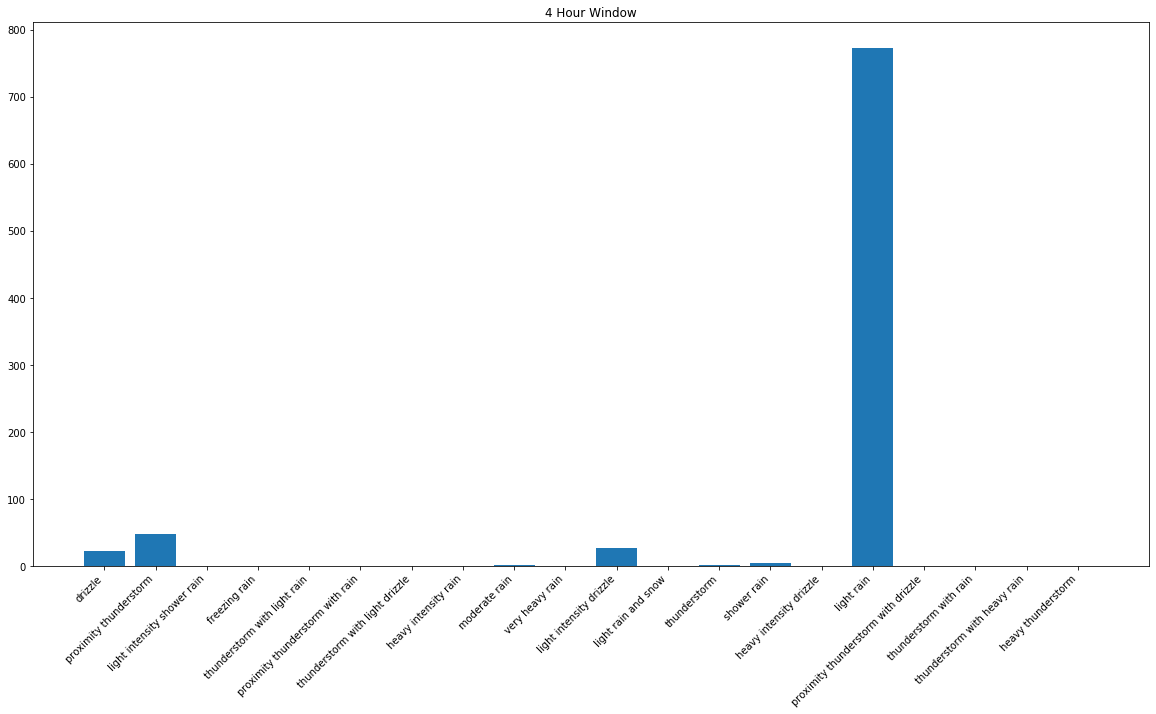

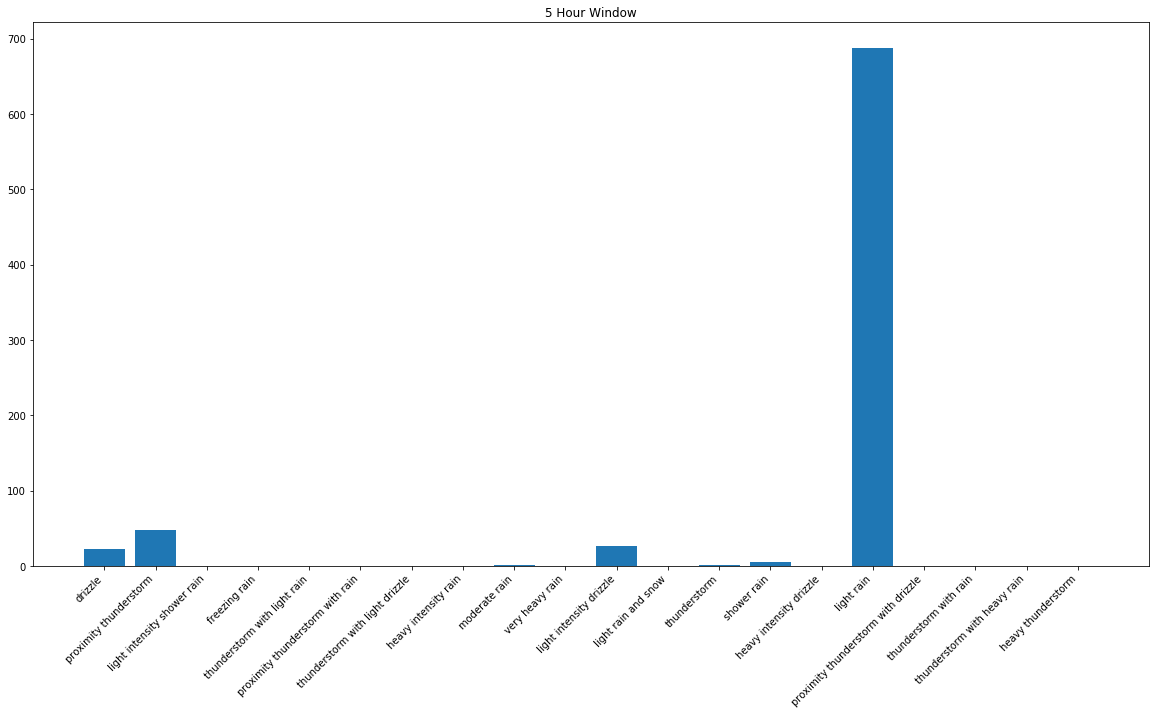

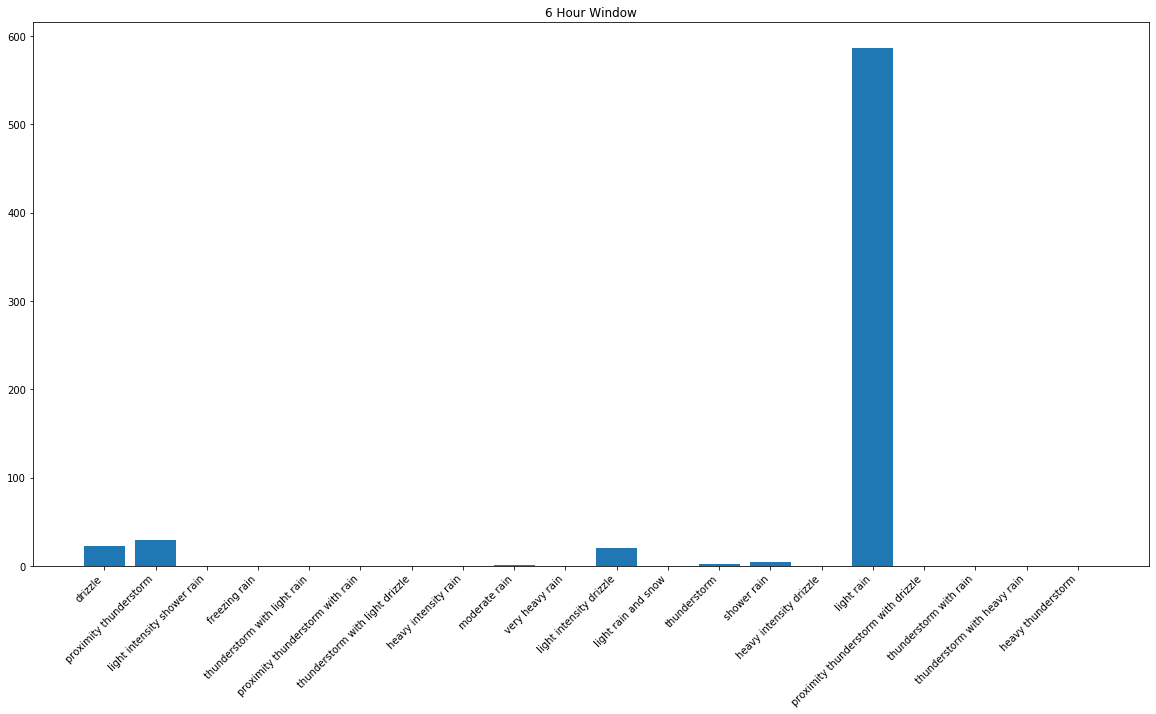

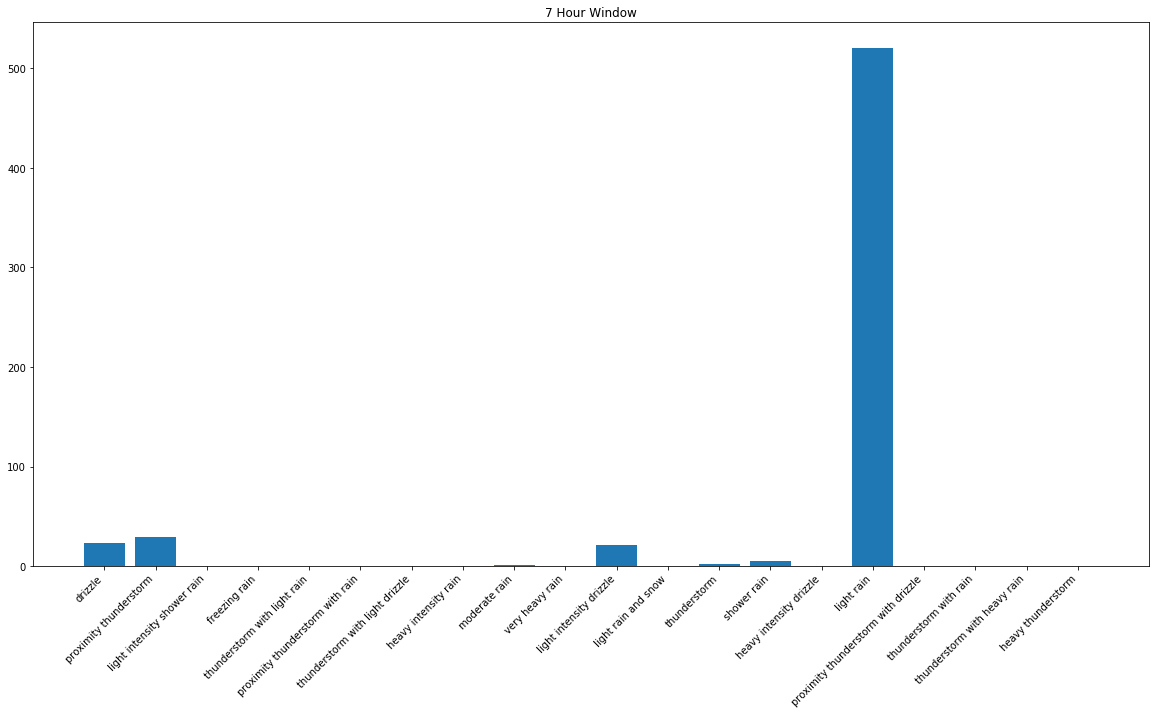

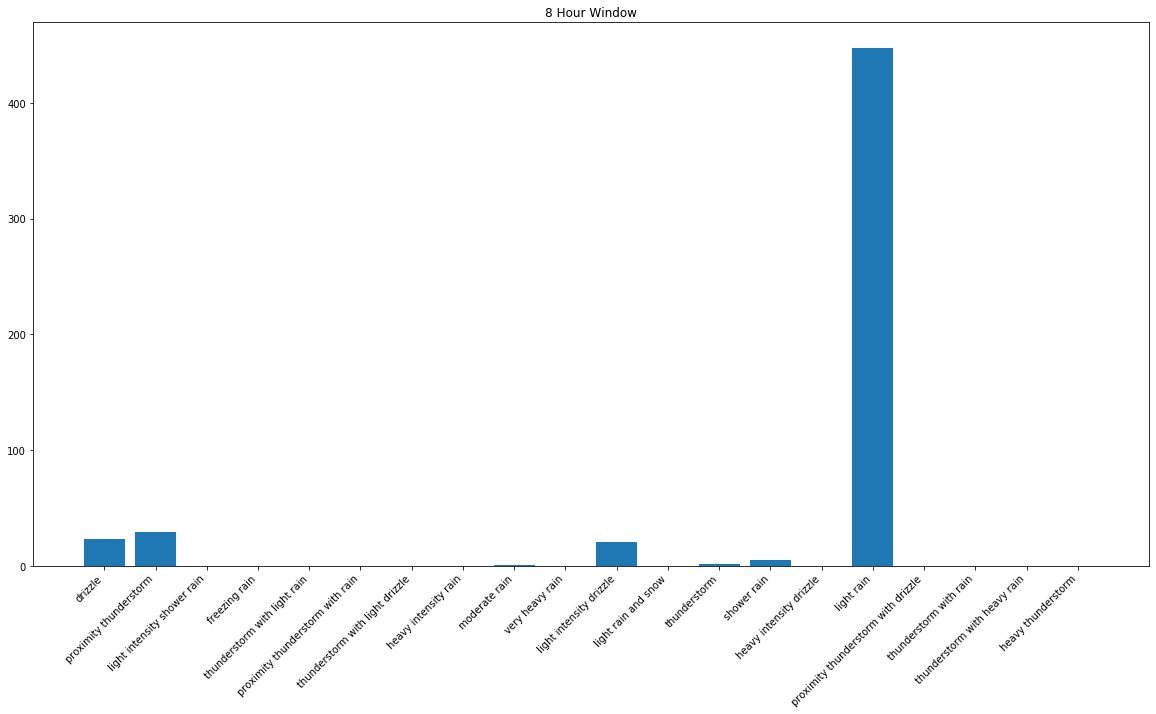

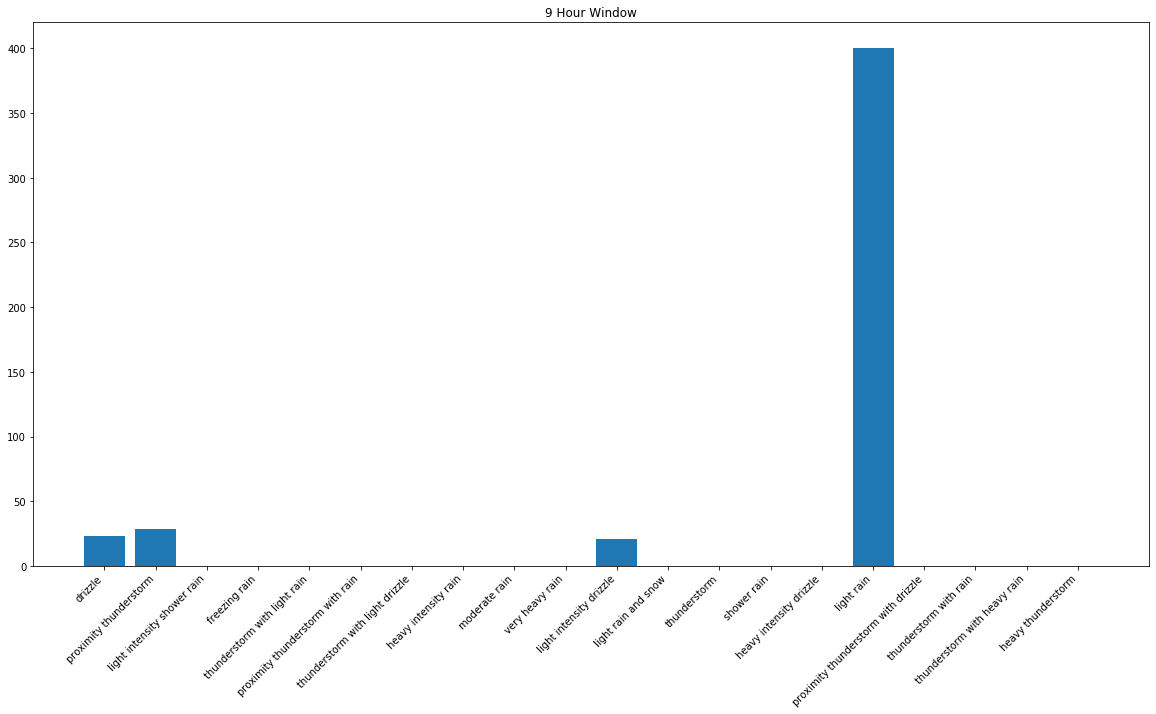

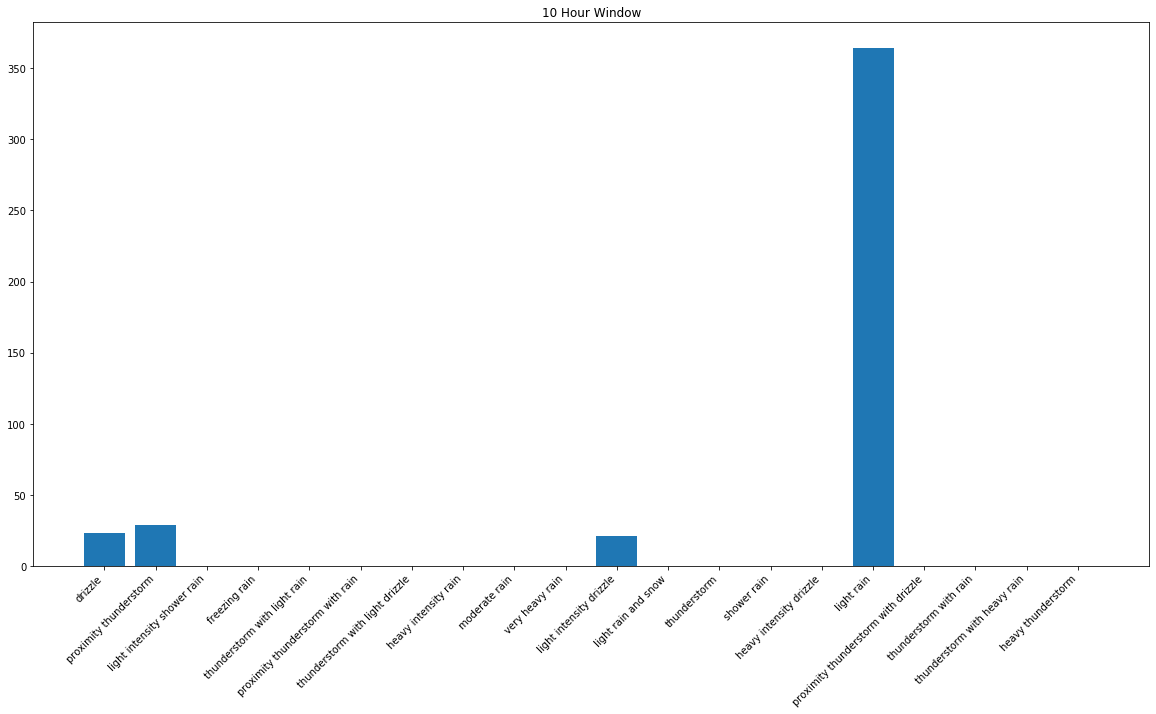

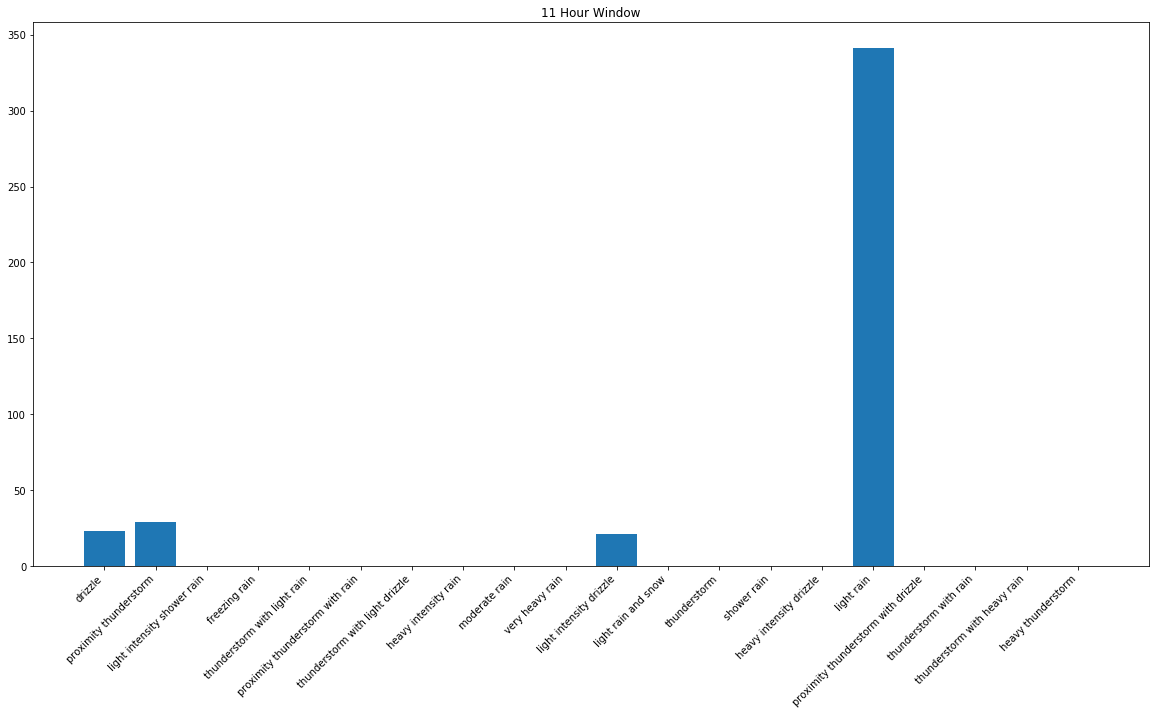

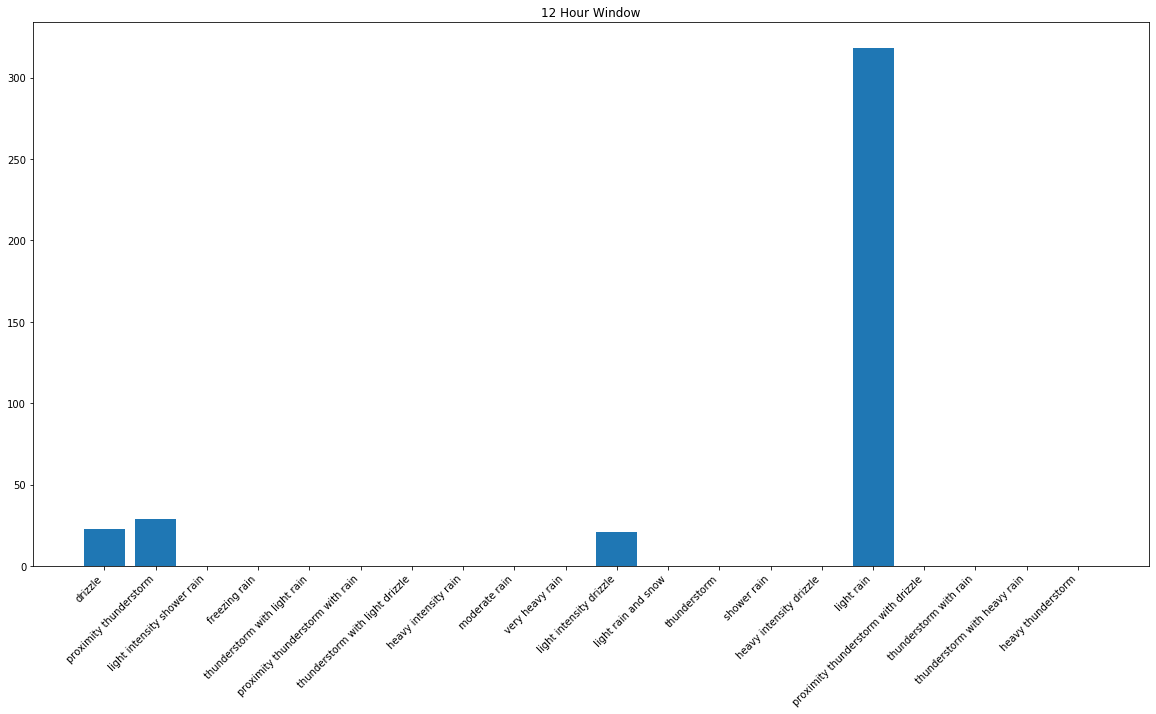

In [111]:
for key, rain_dict in fn_rain_prevalence_dict_collection.items():
    fig, ax = plt.subplots(figsize=(20,10))
    plt.bar(range(len(rain_dict)), list(rain_dict.values()), align='center')
    plt.xticks(range(len(rain_dict)), list(rain_dict.keys()))
    ax.set_xticklabels(list(rain_dict.keys()), rotation = 45, ha="right")
    plt.title('{} Hour Window'.format(key))
    plt.show()
    plt.close()

Looks like my current model really "hates" to predict "light rain" in the middle of few hours of no rain. Again, like I previously mentioned, I think adding the mapping from rain or even other weather conditions to numerical values can help in this case. 

### Step 7: What's next?

Based on initial model explorations and  observations from the preliminary failure analysis. Here are a list of things I'd like to try next:


<b> 1) Add More features from weather descriptions and change the target to categorical classification</b>


<b> 2) More data cleaninng and preparation </b>
>- use better imputation method for missing values in weather conditions.
>- identify and remove potential outlier data points if observed any in the dataset, and do interpolation/imputation on the missing data after outlier removal. Re-generate the train, validation and training dataset and see if I can make the performance better.

<b> 3) More Failure Analysis + Parameter Tuning </b>
>- More FA will be needed after step 1&2 to see if I can find any patterns in the failed cases and use the discoveries to tune the model, loss or feature extraction methodologies accordingly.

<b> 4) Model Explorations </b>
>- create separate models, each one will train with dataset generated with different configs (variable input sequence length and gap length). Then combine the results from different models with some weighting techniques. <br>



>- In parallel, I also want to take a step back and try a different approach:<br>If doing a multivariate multi-step one-shot prediciton is too aggressive, can we divide and conquer things using separate models to achieve one small task at a time? Some thoughts: Divide N Conquer with Machine Learning Pipeline.


>>This methodology is easier to debug and isolate problem areas compared to end-to-end NN models as a big black box. For example, ceiling analysis can be adopted to figure out where one should focus on improving performance in the pipeline.

>><b>Recursive One-step Forecasting + Binary Classifier</b>

>>- Recursive Forecasting:<br>I will first use Multivariate Recursive One-step forecasting model to forecast all weather conditions for next one hour. Then use the predictions as inputs to feed back into the model and generate the next hour predictions. Repeat this recursively until the desired future steps are reached (in this case, 24).
<br>
<br>
>- Binary Classifier:<br>
Every individual hour predicted weather conditions will be passed as inputs to the binary classifier to predict rain condition for the current hour. Do this for all 24 hours.

>><b>Direct Multi-step Forecasting + Binary Classifier</b>

>>- Direct Forecasting:<br>I will first use several Univariate Multi-step forecasting models to forecast each weather condition individually for next 24 hours. Then concatenate all predicted conditions together.
<br>
<br>
>- Binary Classifier:<br>
Every individual hour predicted weather conditions will be passed as inputs to the binary classifier to predict rain condition for the current hour. Do this for all 24 hours.


>><b>Build Grid Search infrastructures to enable different models and different parameters and their performance comparisons</b>

<b> 5) Refactor my code!